In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import glob, re
import pandas as pd
import os
import natsort
import pickle 
import colorsys

from celluloid import Camera
from IPython.display import HTML

from definitions import *

# Density profiles
Show the particle density as a function of the radial distance to the initial point.

In [ ]:
# path = '/home/active-galton/runs/production/1c.BD/ts0.01_rt10000000_s10000_T1_g1_N20000/Frames/'
path = '/home/active-galton/runs/production/1b.LD/ts0.01_rt10000000_s10000_T1_g1_N20000/Frames/'

# path = '/home/active-galton/runs/production/2a.ABP/ts0.01_rt10000000_s2000_N20000_T1e-06_Tr0.3_gt1_gr3_Fp1/Frames/'
# path = '/home/active-galton/runs/production/2b.RTP/ts0.01_rt10000000_s10000_N20000_T1e-09_Tr1e-09_gt1_gr3_Fp1_tr0.001/Frames/'

pathn=os.path.normpath(path)
sim_folder=pathn.split(os.sep)[-2]
filenames = os.listdir(path)
filenames.sort(key=natural_sort_key)
filenames_paths = [path+f for f in filenames]
frames = load_frames(filenames_paths[::1])

In [4]:
nbins=50

time_vec=[]
prob_dens_evol = []
binss = []
kurts = []
for i,frame in enumerate(frames):

    # Como en cada frame el espacio que ocupan las particulas cambia mucho
    # si pintamos los histogramas para los distintos tiempos con los mismos
    # binados, las curvas para tiempos largos nos quedan ruidosas (demasiados bins)
    # y las curvas para tiempos cortos nos quedan muy picudas (insuficientes bins)
    # Para evitarlo hacemos un binado para cada frame, que tenga como limites
    # el min(x) y max(x)
    binlo = frame.boxX[0]
    binhi = frame.boxX[1]
    bins = np.linspace(binlo,binhi,nbins)
    bins_cent = bins[0:-1]+(binhi-binlo)/(2*(nbins-1))

    
    time_vec.append(frame.step)
    clear_output(wait=True)    

    xpos = frame.traj['x'].tolist()
    
    count,_ = np.histogram(xpos, bins=bins, density=True)
    kurt = sp.stats.kurtosis(xpos)
    
    prob_dens_evol.append(count)
    binss.append(bins_cent)
    kurts.append(kurt)
    print(i)
    
prob_dens_evol=np.array(prob_dens_evol)
binss=np.array(binss)
time_vec=np.array(time_vec)
kurts=np.array(kurts)

2000


In [5]:
# Distribución teórica
dt = 0.01
kT = 1
gamma = 1
D = kT/gamma
t = time_vec[-1]*dt
x=bins_cent
dens_theo = 1/(np.sqrt(4*np.pi*D*t))*np.exp(-x**2/(4*D*t))

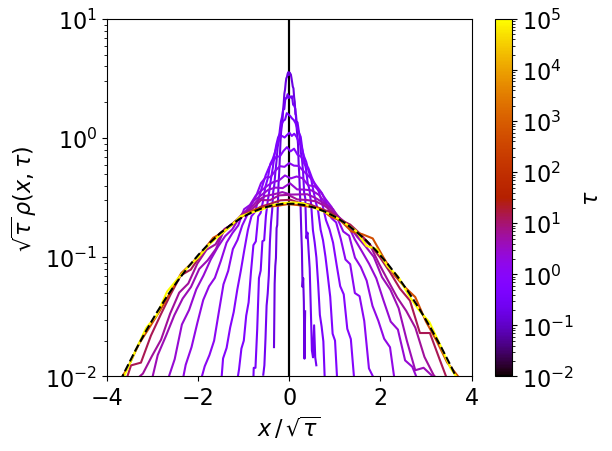

In [56]:
# Elegimos estos tiempos para plotear, espaciados logaritmicamente para observar tanto la evolucion a tiempos cortos como a largos
idxs=np.unique(np.round(np.logspace(0,np.log10(len(frames)),20)-1).astype(int).tolist())

# # Podriamos elegir tambien tiempos espaciados linealmente pero no es tan representativo
# idxs=np.round(np.linspace(0,len(frames)-1,30)).astype(int).tolist()

# # All times
# idxs=np.arange(0,len(time_vec))

times_selected = time_vec[idxs]+1
times_selected = (time_vec[idxs]+1)*0.01
bins_selected = binss[idxs]
prob_dens_evol_selected = prob_dens_evol[idxs]

# Setup the normalization and the colormap
normalize = mpl.colors.LogNorm(vmin=times_selected.min(), vmax=times_selected.max())
colormap = mpl.cm.gnuplot

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots();
for i, probden in enumerate(prob_dens_evol_selected):
    a=ax.plot(bins_selected[i]/np.sqrt(times_selected[i]), probden*np.sqrt(times_selected[i]), lw=1.5, color=colormap(normalize(times_selected[i]))) #, label=r'$\tau=$'f'{np.round(times_selected[i])}');
    
ax.plot(x/np.sqrt(times_selected[-1]), dens_theo*np.sqrt(times_selected[-1]), lw=1.5, ls='dashed', color='k', label='Teoría');

# Si pintamos en escala logaritmica vemos mucho mejor lo que esta pasando
ax.set_yscale('log')
ax.set_xlabel(r'$x\,/\,\sqrt{\tau}$')
ax.set_ylabel(r'$\sqrt{\tau}\,\rho(x,\tau)$')
ax.set_xlim(-4,4)
ax.set_ylim(0.01,10)

sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
fig.colorbar(sm, ax=ax, label=r'$\tau$')
fig.set_tight_layout(True)

In [57]:
# Save plot and data
name='LD_prob-dens-evol_'+sim_folder
results_path_main="/home/active-galton/results/1.LD-BD/"

fig.savefig(results_path_main+name+'.png',dpi=200)

probdensdata = {'time': times_selected,
                'bins': bins_selected,
                'probdens': prob_dens_evol_selected}

with open(results_path_main+name+'.pkl', 'wb') as f:
    pickle.dump(probdensdata, f)


0.99995

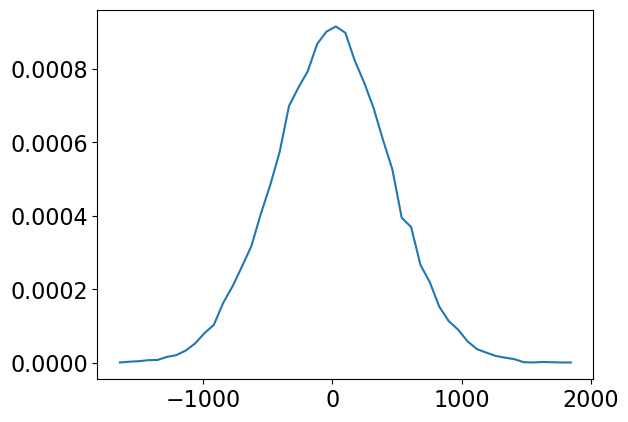

In [11]:
# Check that it is a density distribution (integral = 1)
pd = prob_dens_evol_selected[-1]
plt.plot(binss[-1],pd)
np.trapz(pd,binss[-1])

# Kurtosis

Text(0.5, 0, '$\\tau$')

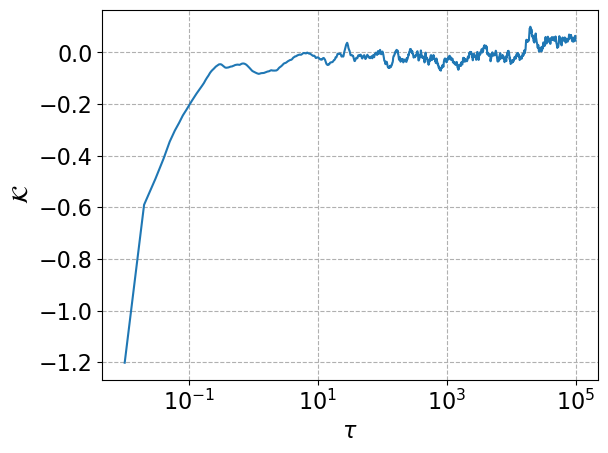

In [58]:
fig,ax = plt.subplots()
ax.plot(time_vec[1:]*dt,kurts[1:])

ax.grid(ls='--')
ax.set_xscale('log')
ax.set_ylabel(r'$\mathcal{K}$')
ax.set_xlabel(r'$\tau$')


In [59]:
# Save plot and data
name='LD_kurtosis_'+sim_folder
results_path_main="/home/active-galton/results/1.LD-BD/"

fig.savefig(results_path_main+name+'.png',dpi=200)

probdensdata = {
    'tau': time_vec[1:]*dt,
    'kurtosis': kurts[1:]
}

with open(results_path_main+name+'.pkl', 'wb') as f:
    pickle.dump(probdensdata, f)
